##**Notebook PC#10 - Part 1**

## Generative Adversarial Networks for the MNIST dataset.

Based on [this content](https://towardsdatascience.com/generative-adversarial-networks-bf4e809180b3), with code corrections.

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Ariel Góes de Castro <br>
**Aluno(a):** Francisco Germano Vogt

**Observação:** <br>
Criamos o código `PC10_P2_GAN_CIFAR10.ipynb`, que realiza as modificações necessárias para uma classe do dataset CIFAR-10 com camadas `Dense`. Porém esse modelo não teve um resultado satisfatório. Por fim, criamos o `PC10_P3_GAN_CIFAR10.ipynb` com os hiperparâmetros recomendados pelo enunciados. Outra versão intermediária com camadas convolucionais também não teve sucesso por causa dos hiperparâmetros utilizados. O melhor resultado encontra-se na última versão (i.e., `PC10_P3_GAN_CIFAR10.ipynb`). Apesar de o Generator acabar tendo um aumento repentino de Loss nas últimas épocas, as imagens geradas para classe cat (classe 3) são mais próximas do esperado para o dataset CIFAR-10.

In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers.legacy import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

import matplotlib.image as mpimg

2024-05-29 14:28:20.368350: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 14:28:20.416744: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 14:28:20.416789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 14:28:20.418025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-29 14:28:20.426337: I tensorflow/core/platform/cpu_feature_guar

In [2]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        d_losses = []
        d_accuracies = []
        g_losses = []

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            d_losses.append(d_loss[0])
            d_accuracies.append(100*d_loss[1])
            g_losses.append(g_loss)

            # Plot the progress
            if epoch % 100 == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

        return d_losses, d_accuracies, g_losses

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("%d.png" % epoch) # Please, define the working directory appropriately
        plt.close()

In [3]:
%%time
gan = GAN()
d_losses, d_accuracies, g_losses = gan.train(epochs=30001, batch_size=128, sample_interval=1000)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 533505 

2024-05-29 14:28:22.842716: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 14:28:22.884893: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 14:28:22.885154: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                     

2024-05-29 14:28:24.500919: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


0 [D loss: 0.524356, acc.: 75.78%] [G loss: 0.587533]
4/4 [==============================] - 0s 2ms/step
100 [D loss: 0.078076, acc.: 98.44%] [G loss: 3.273677]
4/4 [==============================] - 0s 2ms/step
200 [D loss: 0.414830, acc.: 75.78%] [G loss: 2.390133]
4/4 [==============================] - 0s 2ms/step
300 [D loss: 0.665193, acc.: 48.44%] [G loss: 0.632528]
4/4 [==============================] - 0s 2ms/step
400 [D loss: 0.647649, acc.: 49.22%] [G loss: 0.678168]
4/4 [==============================] - 0s 2ms/step
500 [D loss: 0.638187, acc.: 58.98%] [G loss: 0.726792]
4/4 [==============================] - 0s 2ms/step
600 [D loss: 0.661245, acc.: 55.86%] [G loss: 0.782484]
4/4 [==============================] - 0s 2ms/step
700 [D loss: 0.638458, acc.: 60.55%] [G loss: 0.792651]
4/4 [==============================] - 0s 2ms/step
800 [D loss: 0.623684, acc.: 58.20%] [G loss: 0.862338]
4/4 [==============================] - 0s 2ms/step
900 [D loss: 0.581482, acc.: 77.73%] [G

2024-05-29 14:55:10.867265: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 2ms/step
12800 [D loss: 0.645063, acc.: 62.50%] [G loss: 0.892588]
4/4 [==============================] - 0s 2ms/step
12900 [D loss: 0.655672, acc.: 60.16%] [G loss: 0.919689]
4/4 [==============================] - 0s 2ms/step
13000 [D loss: 0.652412, acc.: 60.94%] [G loss: 0.903071]
4/4 [==============================] - 0s 2ms/step
13100 [D loss: 0.631357, acc.: 66.02%] [G loss: 0.882296]
4/4 [==============================] - 0s 3ms/step
13200 [D loss: 0.643759, acc.: 66.41%] [G loss: 0.842444]
4/4 [==============================] - 0s 2ms/step
13300 [D loss: 0.662792, acc.: 60.55%] [G loss: 0.868405]
4/4 [==============================] - 0s 2ms/step
13400 [D loss: 0.652502, acc.: 63.28%] [G loss: 0.890768]
4/4 [==============================] - 0s 2ms/step
13500 [D loss: 0.640722, acc.: 63.67%] [G loss: 0.859386]
4/4 [==============================] - 0s 2ms/step
13600 [D loss: 0.663789, acc.: 56.64%] [G loss: 0.880848]
4/4 [==============

2024-05-29 15:18:36.480657: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 2ms/step
23800 [D loss: 0.670427, acc.: 54.69%] [G loss: 0.900057]
4/4 [==============================] - 0s 2ms/step
23900 [D loss: 0.655366, acc.: 59.38%] [G loss: 0.921156]
4/4 [==============================] - 0s 2ms/step
24000 [D loss: 0.665756, acc.: 57.81%] [G loss: 0.928254]
4/4 [==============================] - 0s 2ms/step
24100 [D loss: 0.649046, acc.: 60.16%] [G loss: 0.866472]
4/4 [==============================] - 0s 2ms/step
24200 [D loss: 0.675175, acc.: 58.59%] [G loss: 0.863969]
4/4 [==============================] - 0s 2ms/step
24300 [D loss: 0.666314, acc.: 57.81%] [G loss: 0.929827]
4/4 [==============================] - 0s 2ms/step
24400 [D loss: 0.640888, acc.: 64.06%] [G loss: 0.883046]
4/4 [==============================] - 0s 2ms/step
24500 [D loss: 0.669152, acc.: 58.98%] [G loss: 0.882923]
4/4 [==============================] - 0s 2ms/step
24600 [D loss: 0.654198, acc.: 62.11%] [G loss: 0.911102]
4/4 [==============

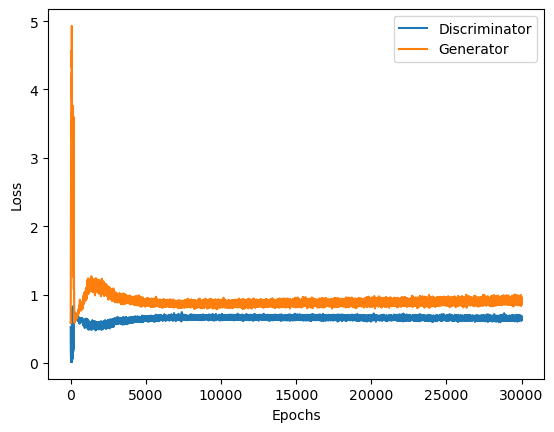

In [4]:
##
## Visualizing training losses
##
import matplotlib.pyplot as plt

plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

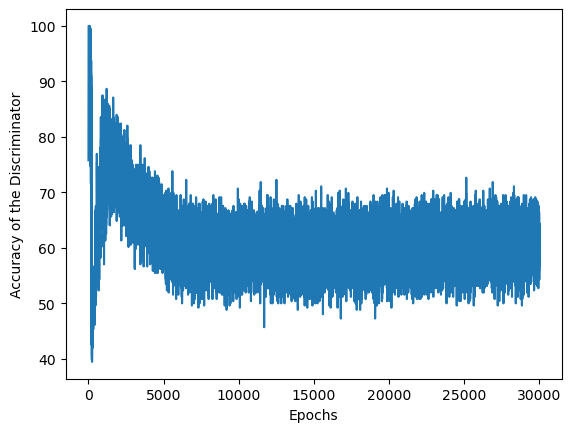

In [5]:
##
## Visualizing discriminator accuracy evolution
##
plt.plot(d_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy of the Discriminator')
plt.show()

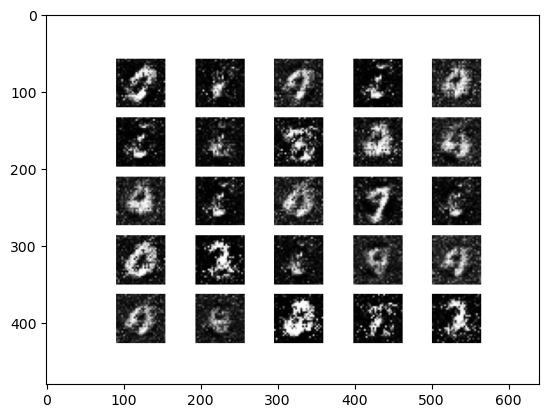

In [6]:
image = mpimg.imread("1000.png")
plt.imshow(image)
plt.show()

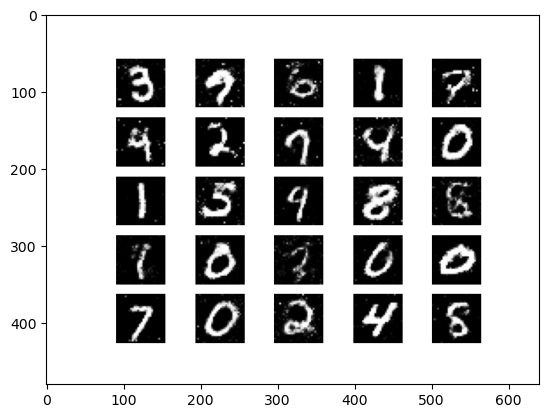

In [7]:
image = mpimg.imread("10000.png")
plt.imshow(image)
plt.show()

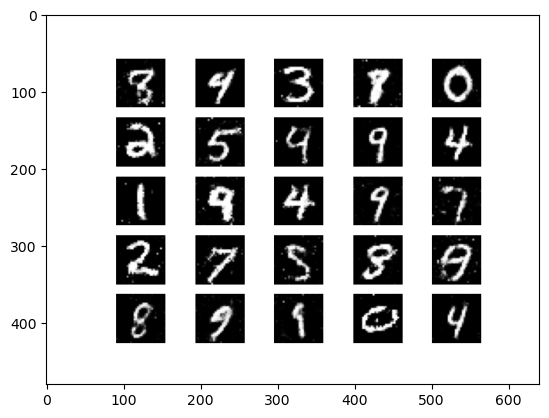

In [8]:
image = mpimg.imread("20000.png")
plt.imshow(image)
plt.show()

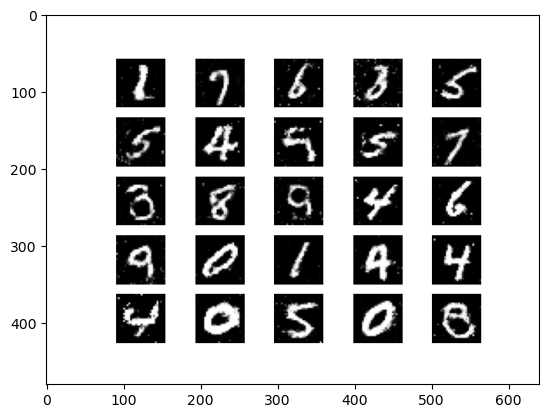

In [9]:
image = mpimg.imread("30000.png")
plt.imshow(image)
plt.show()